In [1]:
import pandas as pd
import os
import matplotlib as plt
import seaborn as sns
import regex as re
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Functions

In [2]:
def build_result_df(distance_measure, directory_path):
    """
    Build a DataFrame that compiles module distances between disease pairs from multiple CSV files.

    Parameters:
        distance_measure (str): Name of the column in the CSV files that contains the distance measure.
        directory_path (str): Path to the directory containing CSV files with distance data.

    Returns:
        pd.DataFrame: DataFrame where rows represent disease pairs and columns represent layers.
                      Each cell contains the distance measure for a specific layer and disease pair.
    """

    result_df = pd.DataFrame() # Initalize empty DataFrame to store results
    
    # Loop through all files in the specified dircetory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'): # Only CSV files are processed
            file_path = os.path.join(directory_path, file_name)
            df = pd.read_csv(file_path) # Load CSV file in a DataFrame
            
            # Extracting disease names from the filename with regular expressions
            pattern = 'distances_(.+)-(.+)_seeds_.+'
            diseases = re.findall(pattern, file_name)
            diseases_list = [disease.replace('_', ' ') for disease in list(diseases[0])]
    
            # Select and rename columns for standardization
            data = df[['Layer', distance_measure]]
            data = data.rename(columns={distance_measure: 'Distance'})
            data['Layer'] = data['Layer'].str.replace('_', ' ')
            
            # Transpose data so that each layer becomes a column and each row a disease pair
            transposed_data = data.T
            transposed_data = data.set_index('Layer').T
            transposed_data.index = [f"{diseases_list[0]} - {diseases_list[1]}"]
    
            # Concatenate with the results
            result_df = pd.concat([result_df, transposed_data])
    
    result_df.index.name = 'Disease pair' # Label the index
    return result_df

In [3]:
def create_hexbin_plot(
        x_values,
        y_values,
        x_label,
        y_label,
        limits = [-2, 4, -1, 1],
        save_path = None,
        cbar = False
        ):
    
    """
    Create a hexbin plot to visualize the distribution of distances measured between modules by sAB.

    Parameters:
        x_values (pd.Series): x-axis values (distance measures for disease pairs).
        y_values (pd.Series): y-axis values (another set of distance measures for disease pairs).
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        axis_limits (list): Limits for the plot axes in the format [x_min, x_max, y_min, y_max].
        save_path (str, optional): File path to save the plot as a PDF.
        show_colorbar (bool): If True, display a color bar to indicate counts in hex bins.
    """

    #Specifying the color palette
    palette = sns.cubehelix_palette(start=.5, rot=-.5, light = 0.9, as_cmap=True)
    
    # Define joint plot and settings
    joint_kws = dict(gridsize=70, mincnt=1)  # Adjusted gridsize for hex bins
    fig = sns.jointplot(x=x_values, y=y_values, kind="hex", cmap=palette, color = 'black',
                        marginal_ticks=True, joint_kws=joint_kws, space =0.5, height = 7.3)

    # Adjust the tick size on the marginal axes
    fig.ax_marg_x.tick_params(axis='both', labelsize=22) 
    fig.ax_marg_y.tick_params(axis='both', labelsize=22)
    
    # Setting the axis labels
    fig.set_axis_labels(x_label, y_label, fontsize = 25)
    
    # Add reference line for where the zero axis are
    fig.refline(x=0, y=0, color = 'grey')
    
    # Setting axis limits
    fig.ax_joint.set_xlim(limits[0], limits[1])
    fig.ax_joint.set_ylim(limits[2], limits[3])

    # Inverting axis to make overlap be on the right
    fig.ax_joint.invert_xaxis()
    fig.ax_joint.invert_yaxis()

    # Remove the default ticks on the main plot
    fig.ax_joint.set_xticks([])
    fig.ax_joint.set_yticks([])

    # Calculate midpoints between 0 and the max/min for ticks
    x_tick_midpoint_low = (0 + limits[0]) / 2
    y_tick_midpoint_low = (0 + limits[2]) / 2

    x_tick_midpoint_high = (0 + limits[1]) / 2
    y_tick_midpoint_high = (0 + limits[3]) / 2

    # Set custom ticks (midpoint between 0 and max/min)
    plt.xticks([x_tick_midpoint_low, x_tick_midpoint_high], ['Overlap', 'No overlap'], fontsize=25)
    plt.yticks([y_tick_midpoint_low, y_tick_midpoint_high], ['Overlap', 'No overlap'], fontsize=25, rotation = 0)

    # Remove the spines (the default border lines for x and y axes)
    fig.ax_joint.spines['left'].set_color('none')
    fig.ax_joint.spines['bottom'].set_color('none')

    # Create arrow-style axes
    arrowprops = dict(facecolor='black', arrowstyle="-|>,head_width=0.7,head_length=1.2")  # Adjusted arrowhead size

    fig.ax_joint.annotate('', xy=(1, 0), xytext=(0, 0), 
                          arrowprops=arrowprops, 
                          xycoords='axes fraction', textcoords='axes fraction')
    fig.ax_joint.annotate('', xy=(0, 1), xytext=(0, 0), 
                          arrowprops=arrowprops, 
                          xycoords='axes fraction', textcoords='axes fraction')

    # Add colorbar if specified
    if cbar:
        cbar_ax = fig.fig.add_axes([1.05, 0.05 , 0.04, 0.9])  # make new ax object for the cbar
        cbar = plt.colorbar(cax=cbar_ax, orientation='vertical')
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label('Counts', fontsize = 25)

    # Saving the plot as a pdf if specified
    if save_path:
        fig.savefig(save_path, format='pdf')
    
    plt.show()

# Analysis

## Results for disease multiplex derived modules

In [4]:
directory = '../00_Data/Distance_results/distances_seeds_1_disease-multiplex-020924_module_30'
df_disease_multiplex = build_result_df(
    distance_measure = 'sAB',
    directory_path = directory
    )

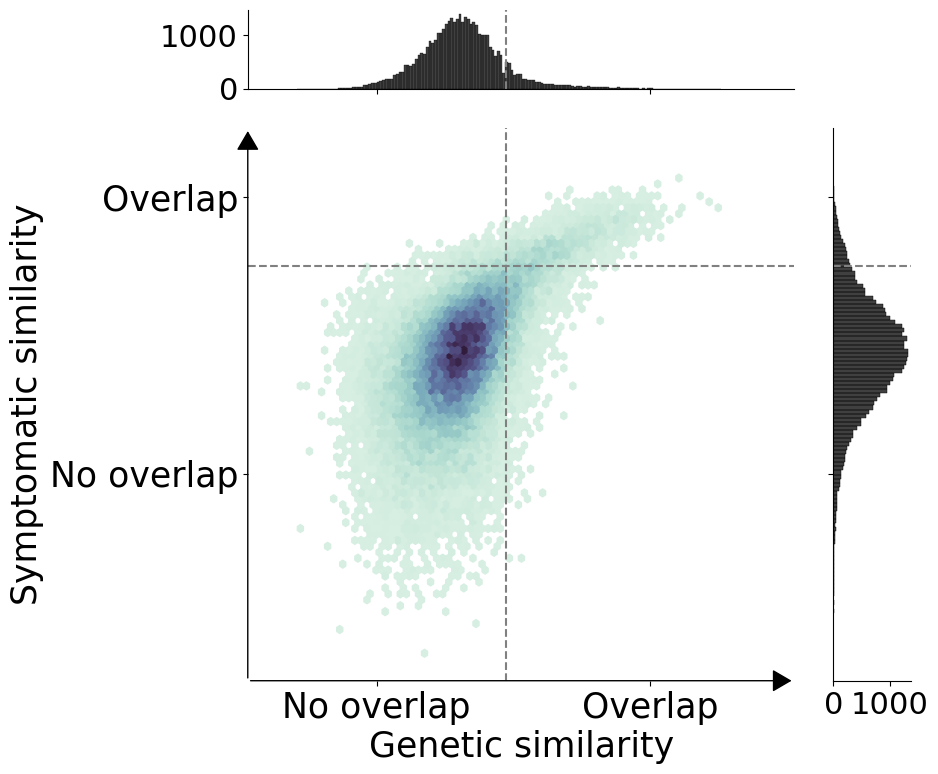

In [5]:
create_hexbin_plot(
    list(df_disease_multiplex['disease on genes']),
    list(df_disease_multiplex['disease on symptoms']), 
    'Genetic similarity', 'Symptomatic similarity', 
    limits = [-1.4, 1.25, -2, 6]
    )

## Results for multiplex-heterogenoeus network derived modules

In [6]:
directory = '../00_Data/Distance_results/distances_seeds_30_het_multiplex_dis_0209_gene_1309_disease_results_module_30'
df_multiplex_heterogeneous = build_result_df(
    distance_measure = 'sAB',
    directory_path = directory
    )

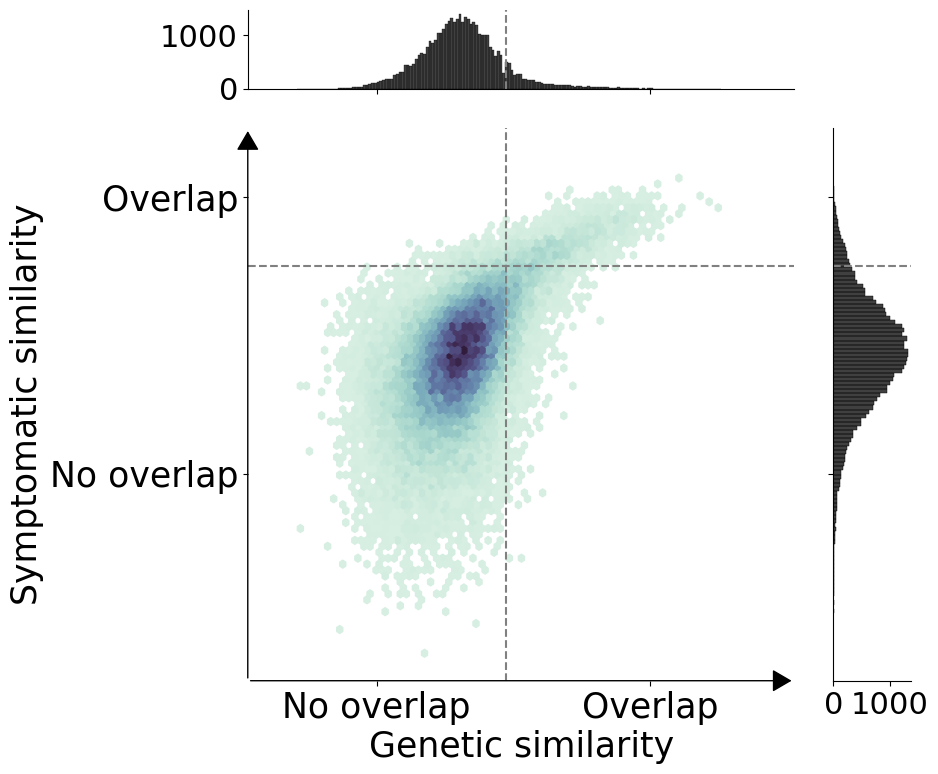

In [ ]:
create_hexbin_plot(
    list(df_multiplex_heterogeneous['disease on genes']),
    list(df_multiplex_heterogeneous['disease on symptoms']), 
    'Genetic similarity', 'Symptomatic similarity', 
    limits = [-1.4, 1.25, -2, 6]
    )